<img src="./image/Title.png">

### 패키지 import 및 bundle 객체 선언

In [1]:
import cv2
import numpy as np
import modi
import time

Running PyMODI (v1.0.1)


In [2]:
bundle = modi.MODI(ai_mode=True)
ai_cam = bundle.ai_cameras[0]
motor = bundle.motors[0]
print('bundle finish')

Initiating can connection...
Start initializing connected MODI modules
Motor (2352) has been connected!
MODI modules are initialized!
MODI AI modules are initialized!
bundle finish


### 선 이미지 출력 함수

In [3]:
def t_display_lines(image, lines):
    line_image = np.zeros_like(image)
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line.reshape(4)
            cv2.line(line_image, (x1, y1), (x2, y2), (255, 0, 0), 10)
    return line_image

### Canny function
##### 윤곽선 추출

In [4]:
# Canny 이미지 처리함수
def canny(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    canny = cv2.Canny(blur, 50, 150)
    return canny

In [ ]:
ai_cam.set_window()
ai_cam.set_frame_height(320)
ai_cam.set_frame_weight(240)
while True:
    frame = ai_cam.read()
    frame = cv2.flip(frame, 1)
    canny_image = canny(frame)
    ai_cam.show(canny_image)

### ROI (Region Of Interest)
##### 영역 설정

In [5]:
# Roi 설정 함수 (카메라 화각이 좁은 관계로 화면 전체를 잡은 상태)
def region_of_interest(image):
    width = image.shape[1]
#     polygons = np.array([[(0,320),(width,320),(width,0),(0,0)]])
    polygons = np.array([[(0,50), (width,50),(width,480),(0,480)]])
    mask = np.zeros_like(image)
    cv2.fillPoly(mask, polygons, 255)
    masked_image = cv2.bitwise_and(image, mask)
    return masked_image

In [ ]:
ai_cam.set_window()
while True:
    frame = ai_cam.read()
    frame = cv2.flip(frame, 1)
    canny_image = canny(frame)
    cropped_image = region_of_interest(canny_image)
    ai_cam.show(cropped_image)

### Hough Lines
##### 직선 추출

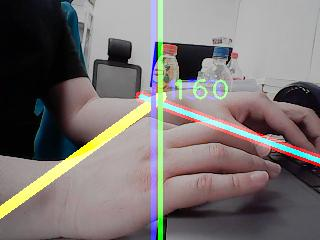

KeyboardInterrupt: 

In [6]:
ai_cam.set_window()
while True:
    frame = ai_cam.read()
    frame = cv2.flip(frame, 1)
    canny_image = canny(frame)
    cropped_image = region_of_interest(canny_image)
    
#     lines = cv2.HoughLinesP(cropped_image, 0.8 , np.pi/180, 10, np.array([]), minLineLength=40, maxLineGap=200)
    lines = cv2.HoughLinesP(cropped_image, 7 , np.pi/180, 41, np.array([]), minLineLength=25, maxLineGap=20)
    frame_lines = t_display_lines(frame, lines)
    
    combo_image = cv2.addWeighted(frame, 0.8, frame_lines, 1, 1)
    
    ai_cam.show(combo_image)

### Average Slope
##### 기울기 처리

In [7]:
# 선 좌표 처리함수
def make_coordinates(image, line_parameters):
    try:
        slope, intercept = line_parameters
        y1 = image.shape[0]
        y2 = int(y1*(2/5))

        x1 = int((y1 - intercept)/slope)
        x2 = int((y2 - intercept)/slope)
        return np.array([x1, y1, x2, y2])
    except:
        pass

# 선 기울기 처리함수
def average_slope_intercept(image, lines):
    left_fit = []
    right_fit = []
    for line in lines:
        x1, y1, x2, y2 = line.reshape(4)
        parameters = np.polyfit((x1, x2), (y1, y2), 1)
        slope = parameters[0]
        intercept = parameters[1]
        if slope < -0.5:
            left_fit.append((slope, intercept))
        elif 0.5 < slope:
            right_fit.append((slope, intercept))
    if (len(left_fit) != 0):
        left_fit_average = np.average(left_fit, axis=0)
    else:
        left_fit_average = ((-5, 240))
    if (len(right_fit) != 0):
        right_fit_average = np.average(right_fit, axis=0)
    else:
        right_fit_average = ((5, -1360))
    left_line = make_coordinates(image, left_fit_average)
    
    rigth_line = make_coordinates(image, right_fit_average)
    return np.array([left_line, rigth_line])


In [8]:
def average_slope_intercept(image, lines):
    """
    Find the slope and intercept of the left and right lanes of each image.
        Parameters:
            lines: The output lines from Hough Transform.
    """
    left_lines    = [] #(slope, intercept)
    left_weights  = [] #(length,)
    right_lines   = [] #(slope, intercept)
    right_weights = [] #(length,)
    
    for line in lines:
        for x1, y1, x2, y2 in line:
            if x1 == x2:
                continue
            slope = (y2 - y1) / (x2 - x1)
            intercept = y1 - (slope * x1)
            length = np.sqrt(((y2 - y1) ** 2) + ((x2 - x1) ** 2))
            if slope < 0:
                left_lines.append((slope, intercept))
                left_weights.append((length))
            else:
                right_lines.append((slope, intercept))
                right_weights.append((length))
    left_lane  = np.dot(left_weights,  left_lines) / np.sum(left_weights)  if len(left_weights) > 0 else None
    right_lane = np.dot(right_weights, right_lines) / np.sum(right_weights) if len(right_weights) > 0 else None
    left_line = make_coordinates(image, left_lane)
    right_line = make_coordinates(image, right_lane)
    return np.array([left_line, right_line])
#     return left_lane, right_lane

def pixel_points(y1, y2, line):
    """
    Converts the slope and intercept of each line into pixel points.
        Parameters:
            y1: y-value of the line's starting point.
            y2: y-value of the line's end point.
            line: The slope and intercept of the line.
    """
    if line is None:
        return None
    slope, intercept = line
    x1 = int((y1 - intercept)/slope)
    x2 = int((y2 - intercept)/slope)
    y1 = int(y1)
    y2 = int(y2)
    return ((x1, y1), (x2, y2))

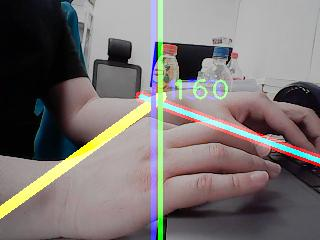

[[ 99 240 209  96]
 [304 240 154  96]]
[[  4 240 171  96]
 [313 240 158  96]]
[[ 38 240 160  96]
 [364 240 144  96]]
[[ 77 240 216  96]
 [393 240 161  96]]
[[-82 240 110  96]
 [690 240 159  96]]
[[-32 240 122  96]
 [812 240 188  96]]
[[-197  240  188   96]
 [ 368  240  142   96]]
[[ 24 240 102  96]
 [295 240 130  96]]
[[ 42 240 119  96]
 [427 240 189  96]]
[[153 240 252  96]
 [411 240 183  96]]
[[ 52 240 209  96]
 [536 240 172  96]]
[[118 240 187  96]
 [331 240 139  96]]
[[ 88 240 203  96]
 [313 240 162  96]]
[[ 84 240 193  96]
 [393 240 132  96]]
[[170 240 276  96]
 [200 240 134  96]]
[[ 31 240 207  96]
 [369 240 137  96]]
[[ 83 240 219  96]
 [382 240 155  96]]
[[-19 240 210  96]
 [368 240 138  96]]
[[ 71 240 200  96]
 [453 240 180  96]]
[[101 240 169  96]
 [348 240 157  96]]
[[140 240 193  96]
 [255 240 148  96]]
[[ 92 240 189  96]
 [278 240 151  96]]
[[ 63 240 187  96]
 [333 240 170  96]]
[[ 30 240 176  96]
 [340 240 165  96]]
[[ 65 240 229  96]
 [296 240 107  96]]
[[ 37 240 201  96

[[-11 240 168  96]
 [287 240 125  96]]
[[ 55 240 220  96]
 [218 240 151  96]]
[[ 21 240 221  96]
 [226 240 155  96]]
[[ 96 240 181  96]
 [208 240 157  96]]
[[ 66 240 240  96]
 [338 240 164  96]]
[[ 60 240 225  96]
 [217 240 147  96]]
[[ 34 240 230  96]
 [263 240 148  96]]
[[ 75 240 170  96]
 [290 240 180  96]]
[[ 65 240 227  96]
 [223 240 108  96]]
[[ 50 240 186  96]
 [274 240 145  96]]
[[ 83 240 203  96]
 [209 240 147  96]]
[[ 38 240 201  96]
 [357 240 139  96]]
[[ 40 240 198  96]
 [362 240 144  96]]
[[126 240 184  96]
 [316 240 151  96]]
[[122 240 169  96]
 [275 240 138  96]]
[[ 76 240 172  96]
 [237 240 167  96]]
[[-24 240 173  96]
 [305 240 192  96]]
[[-28 240 197  96]
 [343 240 140  96]]
[[120 240 222  96]
 [608 240 147  96]]
[[-38 240 185  96]
 [367 240 235  96]]
[[ 88 240 235  96]
 [288 240 158  96]]
[[ 84 240 243  96]
 [396 240 252  96]]
[[ 37 240 170  96]
 [439 240 226  96]]
[[ -7 240 267  96]
 [419 240 244  96]]
[[218 240 299  96]
 [397 240 134  96]]
[[245 240 310  96]
 [402 

KeyboardInterrupt: 

In [9]:

ai_cam.set_window()
while True:
    frame = ai_cam.read()
    frame = cv2.flip(frame, 1)
    canny_image = canny(frame)
    cropped_image = region_of_interest(canny_image)
    
    lines = cv2.HoughLinesP(cropped_image, 7 , np.pi/180, 41, np.array([]), minLineLength=25, maxLineGap=20)
    if str(type(lines)) == "<class 'NoneType'>":
        lines = [[[0, 0 ,0 ,0]]]
    elif len(lines) < 2:
        continue

    # 선분이 2개 검출될때 실행 
    if len(lines) >= 2 :
        averaged_lines = average_slope_intercept(frame, lines)
            
        frame_lines = t_display_lines(frame, averaged_lines)

        combo_image = cv2.addWeighted(frame, 0.8, frame_lines, 1, 1)

        ai_cam.show(combo_image)

### Find Vanishing
##### 소실점 추출

In [10]:
# 중심 축과 검출된 선들의 중심축 좌표 출력 함수 
def find_vanishing(image, lines):
    
    x11, y11, x12, y12 = lines[0]
    cv2.line(image, (x11, y11), (x12, y12), (255, 255, 0), 10)
    x21, y21, x22, y22 = lines[1]
    cv2.line(image, (x21, y21), (x22, y22), (0, 255, 255), 3)
    m1 = (y12 - y11) / (x12 - x11)
    m2 = ((y22 - y21) / (x22 - x21)) -0.001
    cx = int((x11 * m1 - y11 - x21 * m2 + y21) / (m1 - m2))
    center = int(image.shape[1]/2)

    
    cv2.line(image, (cx, 0), (cx, image.shape[0]), (0, 0, 255), 3) 
    cv2.putText(image, str(cx), (cx+10, 100), cv2.FONT_HERSHEY_PLAIN, 2, (0, 0, 255), 2)
    cv2.line(image, (center, 0), (center, image.shape[0]), (0, 255, 0), 3)
    cv2.putText(image, str(center), (center+10, 100), cv2.FONT_HERSHEY_PLAIN, 2, (0, 255, 0), 2)

    return image, cx, center


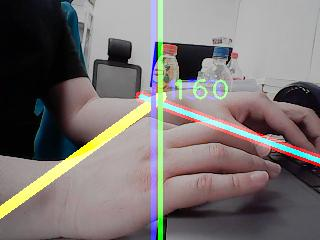

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.nd

KeyboardInterrupt: 

In [11]:
ai_cam.set_window()
while True:
    frame = ai_cam.read()
    frame = cv2.flip(frame, 1)
    canny_image = canny(frame)
    cropped_image = region_of_interest(canny_image)
    
    lines = cv2.HoughLinesP(cropped_image, 7 , np.pi/180, 41, np.array([]), minLineLength=25, maxLineGap=20)
    
    if str(type(lines)) == "<class 'NoneType'>":
        lines = [[[0, 0 ,0 ,0]]]
    elif len(lines) < 2:
        continue

    # 선분이 2개 검출될때 실행 
    if len(lines) >= 2 :
        averaged_lines = average_slope_intercept(frame, lines)
        line_image = t_display_lines(frame, averaged_lines)
        print(type(averaged_lines))
        vanishing_line, vanishing, center = find_vanishing(line_image, averaged_lines)
        combo_image = cv2.addWeighted(frame, 0.8, vanishing_line, 1, 1)
        ai_cam.show(combo_image)

### 모터 & 차량 제어

In [ ]:
# # MODI 모터 제어 함수 
# def forward(delay=1, speed=60):
#     motor.speed= 0, 0
# #     time.sleep(0.001)
#     for _ in range(delay):
# #         time.sleep(0.001)
#         motor.speed= speed, -speed
#         time.sleep(0.001)
#     motor.speed =0, 0

# def left(delay=1):
#     motor.speed= 0,0
# #     time.sleep(0.001)
#     for _ in range(delay):
# #         time.sleep(0.001)
#         motor.speed= 60, 60
#         time.sleep(0.001)
#     motor.speed =0, 0

# def right(delay=1):
#     motor.speed = 0, 0
# #     time.sleep(0.001)
#     for _ in range(delay):
# #         time.sleep(0.001)
#         motor.speed= -60, -60
#         time.sleep(0.001)
#     motor.speed = 0, 0

    
# MODI 모터 제어 함수 
def forward():
    motor.speed= 50, -50
#     time.sleep(0.001)
#     motor.speed= 0,0

def left():
    motor.speed= 35, -25
#     time.sleep(0.001)
#     motor.speed= 0,0

def right():
    motor.speed = 25, -35
#     time.sleep(0.001)
#     motor.speed= 0,0
    
    
# 차량 이동 함수 
def find_way(vanishing, center):
    diff = vanishing - center
    if diff < -15:
        left()
        if diff < -40:
            motor.speed= 50, -25
            time.sleep(0.01)
            if diff < -50:
                motor.speed= 55, -25
                time.sleep(0.01)
                if diff < -60:
                    motor.speed= 60, -25
                    time.sleep(0.01)
                    if diff < -120:
                        motor.speed= 80, -25
                        time.sleep(0.1)
    elif diff > 15:
        right()
        if diff > 40:
            motor.speed= 25, -50
            time.sleep(0.01)
            if diff > 50:
                motor.speed=25, -55
                time.sleep(0.01)
                if diff > 60:
                    motor.speed= 25, -60
                    time.sleep(0.01)
                    if diff > 120:
                        motor.speed= 25, -80
                        time.sleep(0.1)
    else:
        forward()

In [ ]:
ai_cam.set_window()
while True:
    frame = ai_cam.read()
    frame = cv2.flip(frame, 1)
    canny_image = canny(frame)
    cropped_image = region_of_interest(canny_image)
    
#     lines = cv2.HoughLinesP(cropped_image, 0.8 , np.pi/180, 15, np.array([]), minLineLength=40, maxLineGap=200)
    lines = cv2.HoughLinesP(cropped_image, 7 , np.pi/180, 41, np.array([]), minLineLength=25, maxLineGap=20)
    
    if str(type(lines)) == "<class 'NoneType'>":
        lines = [[[0, 0 ,0 ,0]]]
    elif len(lines) < 2:
        continue

    # 선분이 2개 검출될때 실행 
    if len(lines) >= 2 :
        averaged_lines = average_slope_intercept(frame, lines)
        line_image = t_display_lines(frame, averaged_lines)
        vanishing_line, vanishing, center = find_vanishing(line_image, averaged_lines)
        combo_image = cv2.addWeighted(frame, 0.8, vanishing_line, 1, 1)
        ai_cam.show(combo_image)
        find_way(vanishing, center)

# 확인 문제

### Open CV 이미지 처리

#### 1. 직선을 1개만 추출하려면 어떻게 해야할까요?
#### 2. canny를 적용하지 않고 나머지 코드를 실행하면 어떤 결과가 나올까요?
#### 3. grayscale을 적용하지 않고 나머지 코드를 실행하면 어떤 결과가 나올까요?